
## Scikit-Optimize

Scikit-Optimize é uma biblioteca de otimização que fornece ferramentas para minimizar (ou maximizar) funções de maneira eficiente. Ela é especialmente útil para a otimização de hiperparâmetros em modelos de machine learning. A função `dummy_minimize` utilizada neste projeto é uma abordagem de otimização que tenta minimizar a função objetivo de forma aleatória, sendo útil para comparações com métodos mais sofisticados.

## Conclusão

Este projeto demonstra como utilizar a biblioteca Scikit-Optimize para otimizar os hiperparâmetros de um modelo de Gradient Boosting. A otimização de hiperparâmetros é uma etapa crucial no desenvolvimento de modelos de machine learning, pois pode melhorar significativamente o desempenho do modelo.

In [4]:
!pip install scikit-optimize

In [5]:


import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, train_test_split

from skopt import dummy_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [6]:
#Load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})
X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define hyperparameter space
sckit-optimize provedes an utility function to create the range of values to examine for each hyperparameters

In [8]:
#With integer, we create a space of possible values for the hyperparameter
#between the minimun and maximum values
Integer(10, 120, name='n_estimators')

Integer(low=10, high=120, prior='uniform', transform='identity')

In [9]:
Real(0, 1, name = "min_samples_split")

Real(low=0, high=1, prior='uniform', transform='identity')

In [10]:
#With Categorical, we create a space of possible values for the hyperparameter
Categorical(['deviance', 'exponential'], name='loss')

Categorical(categories=('deviance', 'exponential'), prior=None)

In [28]:
param_grid = [
    Integer(10, 120, name='n_estimators'),
    Real(0, 1, name='min_samples_split'),
    Categorical(['log_loss', 'exponential'], name='loss'),  # Substituído 'deviance' por 'log_loss'
    Integer(1, 5, name='max_depth')
]

## Define the model

In [25]:
gbm = GradientBoostingClassifier(random_state=42)

## Define the objetive function
This is the hyperparameter response space, the function we want to minimize

In [29]:
#We disign a function to maximize the accuracy, of GBM, with cross validation
# The decorator allows our objetivo function tio receibe the parametes as keyword argumts. This is a requirement for skopt

@use_named_args(param_grid)
def objective(n_estimators, min_samples_split, loss, max_depth):
    # Atualiza os parâmetros do modelo
    gbm.set_params(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        loss=loss,
        max_depth=max_depth
    )
    
    # Executa a validação cruzada e obtém as pontuações
    scores = cross_val_score(
        gbm,
        X_train,
        y_train,
        cv=3,
        n_jobs=4,
        scoring='accuracy'
    )
    
    # Calcula a média das pontuações
    mean_score = np.mean(scores)
    
    # Retorna o valor negativo para minimizar (maximizar a acurácia)
    return -mean_score

## Randomized Search


In [30]:
# dummy_minimize will try to minimize the objetive function
search = dummy_minimize(
    objective,
    dimensions=param_grid,
    n_calls=50,
    random_state=42
)

In [31]:
print(search.fun)


-0.9670036017195306


In [32]:
print( """ Best parameters:
- n_estimators = %d
- min_samples_split = %.2f
- loss = %s
- max_depth = %d""" % (search.x[0], search.x[1], search.x[2], search.x[3]))


 Best parameters:
- n_estimators = 98
- min_samples_split = 0.32
- loss = log_loss
- max_depth = 1


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

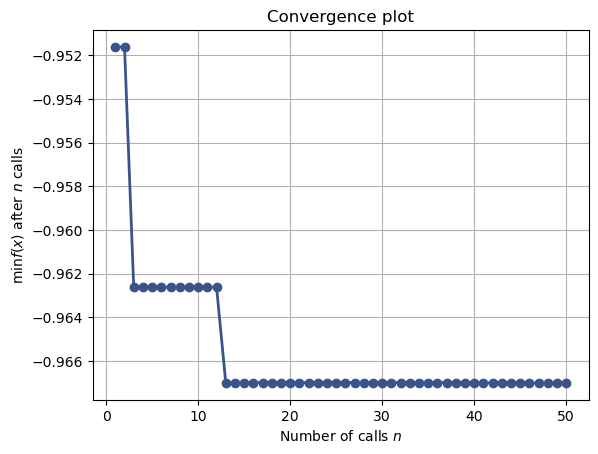

In [35]:
plot_convergence(search)